In [1]:
import tensorflow as tf
import numpy as np
import struct
import gzip
# import matplotlib
import matplotlib.pyplot as plt
from array import array

from flatbuffers.packer import float32
from tensorflow.python.data.experimental.ops.distribute import batch_sizes_for_worker

# my project
from module.conf import PROJECT_DIR
# matplotlib.use("QTAgg")
%matplotlib inline

In [2]:
x = tf.Variable(3.0)

In [3]:
with tf.GradientTape() as tape:
    y = x ** 2
    pass
grad = tape.gradient(y, x)

In [4]:
type(grad.numpy())

numpy.float32

In [5]:
del tape

In [6]:
# def load_data(kind: str) -> tuple[np.ndarray, np.ndarray]:
#     fashion_mnist_path = "/data/sample/fashion_mnist"
#     images_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-images-idx3-ubyte.gz"])
#     labels_path = "".join([PROJECT_DIR, fashion_mnist_path, f"/{kind}-labels-idx1-ubyte.gz"])
#     with gzip.open(labels_path, 'rb') as lbpath:
#         labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

#     with gzip.open(images_path, 'rb') as imgpath:
#         images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28)

#     return np.array(images), np.array(labels)

In [7]:
# # X_train = (np.asarray(X_train)  - 127.5)/ 127.5
# X_train = np.asarray(X_train)
# y_train = np.asarray(y_train)
# # X_test  = (np.asarray(X_test) - 127.5) / 127.5
# X_test  = np.asarray(X_test)
# y_test  = np.asarray(y_test)
# X_train, Y_train = load_data(kind='train')
# X_test, Y_test = load_data(kind='t10k')

In [8]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

In [10]:
class Generator(tf.keras.Model):
    def __init__(self, noise_dim: int, target_shape: tuple):
        super(Generator, self).__init__()
        self.model = tf.keras.Sequential(layers= [
            tf.keras.layers.InputLayer(input_shape=(noise_dim,)),
            tf.keras.layers.Dense(units=256, activation=tf.nn.leaky_relu),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(units=(target_shape[0] * target_shape[1]), activation=tf.nn.tanh),
            tf.keras.layers.Reshape(target_shape=target_shape)
        ])
        return

    def call(self, inputs, training=False):
        return self.model(inputs, training=training)

class Discriminator(tf.keras.Model):
    def __init__(self, target_shape: tuple):
        super(Discriminator, self).__init__()
        self.model = tf.keras.Sequential(layers=[
            # tf.keras.layers.InputLayer(shape=target_shape),
            tf.keras.layers.Flatten(input_shape=target_shape),
            tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu),
            tf.keras.layers.Dropout(rate=0.3),
            tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu),
            tf.keras.layers.Dropout(rate=0.3),
            tf.keras.layers.Dense(units=256, activation=tf.nn.leaky_relu),
            tf.keras.layers.Dropout(rate=0.3),
            tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid),
        ])

    def call(self, inputs, training=False):
        return self.model(inputs, training=training)


In [11]:
class GAN(tf.keras.Model):
    def __init__(self, noise_dim=100, target_shape=[28, 28]):
        super(GAN, self).__init__()
        self.gen_optimizer = None
        self.disc_optimizer = None
        self.loss_fn = None
        self.noise_dim = noise_dim
        self.target_shape = target_shape
        self.generator = Generator(self.noise_dim, self.target_shape)
        self.discriminator = Discriminator(self.target_shape)

    def compile(self, gen_optimizer, disc_optimizer, loss_fn):
        super(GAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.loss_fn = loss_fn
        pass

    def train_step(self, batch):
        batch_sizes = tf.shape(batch)[0]
        # random noise
        noise = tf.random.normal(shape=(batch_sizes, self.noise_dim))
        # gen fake img by Generator
        fake_images = self.generator(noise, training=True)
        # 1 - real image, 0 - fake image
        real_labels = tf.ones((batch_sizes, 1))
        fake_labels = tf.zeros((batch_sizes, 1))

        # train Discriminator
        with tf.GradientTape() as disc_tape:
            real_preds = self.discriminator(batch, training=True)
            fake_preds = self.discriminator(fake_images, training=True)

            real_loss = self.loss_fn(real_labels, real_preds)
            fake_loss = self.loss_fn(fake_labels, fake_preds)

            disc_loss = (real_loss + fake_loss) / 2
            pass
        grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(grad, self.discriminator.trainable_variables))

        # train Generator
        with tf.GradientTape() as gen_tape:
            fake_images = self.generator(noise, training=True)
            fake_preds = self.discriminator(fake_images, training=True)
            gen_loss = self.loss_fn(real_labels, fake_preds)
            pass
        grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(grad, self.generator.trainable_variables))
        return {"gen_loss": gen_loss, "disc_loss": disc_loss}

In [12]:
# dataset = tf.reshape(X_train, [-1, 784]).numpy().shape

In [13]:
# dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(128)
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = (x_train.astype("float64") - 127.5) / 127.5  # Standartize to [-1, 1]
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60_000).batch(512)

In [14]:
# plt.imshow(X_train[0], cmap="gray")
# plt.axis("off")
# plt.show()

In [15]:
# x_train = (X_train.astype("float64") - 127.5) / 127.5
# dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60_000).batch(128)

In [16]:
# tf.config.set_visible_devices()

In [17]:
gan = GAN(noise_dim=512)

gan.compile(
    # gen_optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
    # disc_optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
    # loss_fn=tf.keras.losses.BinaryCrossentropy()
    # gen_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9),
    # disc_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9),
    # loss_fn=tf.keras.losses.BinaryCrossentropy()
    gen_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    disc_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

# gan.fit(dataset, epochs=10000)
# gan.fit(dataset, epochs=1000)

In [18]:
# gan.save_weights(PROJECT_DIR + "/data/models/fashionmnist_gan_1000_2/model")

In [19]:
gan.load_weights(PROJECT_DIR + "/data/models/fashionmnist_gan_1000_2/model")

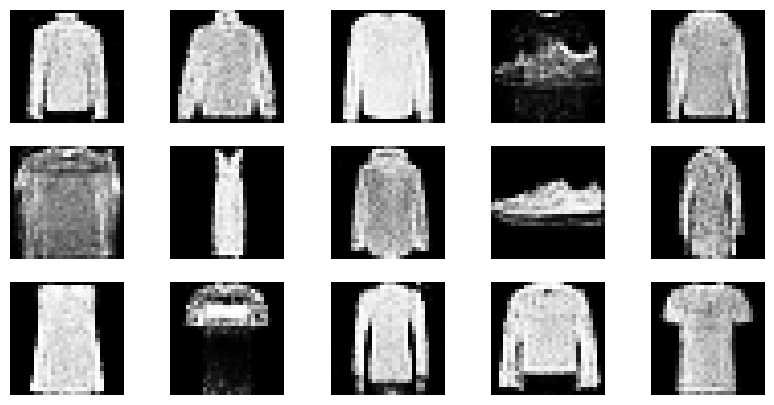

In [ ]:
import matplotlib.pyplot as plt

def generate_and_show_images(generator, num_examples=10):
    noise = tf.random.normal(shape=(num_examples, 512))
    images = generator(noise, training=False)
    images = (images + 1) / 2.0  # standardize to [0, 1]
    rows=4

    fig, axes = plt.subplots(nrows=rows, ncols=num_examples//rows, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
    plt.show()

generate_and_show_images(gan.generator, num_examples=20)